# Assignment 3

*Due on October 28th, 2020*

## Group Members

* Shai Slav (Collaborated on both problems)
* Mark Forese (Collaborated on both problems)


In [26]:
from astropy import units as u
import numpy as np
import matplotlib.pyplot as plt

### Problem One: Thermal Equilibrium in the Interstellar Medium (ISM)

#### Part A (1 point)
* I could give you a trial solution with which to start, but I won’t. That’d be too easy.
* “Ahhh,” you say, “but I can just plot (3) for a particular density to visually obtain my trial solution.” I’m not going to let you do that either. 
* Instead, I’d like you to write a program to figure out approximately where the root lies using the method of bracketing. 
* The idea is simple: 
<ol> <li> Choose two endpoints, T1 and T2 </li>
    <li> if L(n, T<sub>1</sub>) and L(n, T<sub>2</sub>) have opposite signs, then at least one root must lie in that interval </li>
</ol> 
* My advice is to start by setting n = 10−2, T1 = 6000, and T2 = 6001; it’s easy to check by substitution that L < 0 in this tiny range. Your program should increase T2 progressively
* Numerical Recipes iteratively adds 1.6(T2 − T1) to it—until it finds L(n, T<sub>1</sub>)L(n, T<sub>2</sub>) < 0. Record this T<sub>2</sub>; a root lies somewhere between it and T1.

In [27]:
gamma = 2E-26*u.erg / u.s

def lamb(T):
    try:
        T = T.value
    except AttributeError: #this just makes this line of code work if the value of T passed is not an astropy.quantity
        pass
        
    lamb = gamma *(1e7*np.exp(-1.184e5 / (T + 1000)) + 1.4e-2*np.sqrt(T)*np.exp(-92/T))*u.cm**3
    return lamb

def L(n,T):
    return (n*lamb(T)).value - gamma.value

def find_bracket(n,T_1_start,T_2_start):
    L1 = L(n,T_1_start)
    L2 = L(n,T_2_start)
    
    T_1 = T_1_start
    T_2 = T_2_start
    counter = 0
    
    #while the two points evaluate to the same sign
    while(L1*L2 > 0 ):
        counter+=1 
        T_2 += 1.6*(T_2-T_1) #update T2
        L2 = L(n,T_2) #evaluate L at the new T2
        
    return [(T_1,T_2),counter]

In [28]:
n = 1E-2/u.cm**3
T_1_start = 6000*u.K
T_2_start = 6001*u.K

#print(L(n,T_1_start))
#print(L(n,T_2_start))

bracket = find_bracket(n,T_1_start,T_2_start)

In [29]:
print('The bracket is [{:.0f}, {:.0f}], which we found in {} iterations'.format(bracket[0][0],bracket[0][1],bracket[1]))

The bracket is [6000 K, 11430 K], which we found in 9 iterations


#### Part B (2 points)

* Using the bracketed interval you found in part (a), write a program to solve equation (3) for Teq when n = 10−2 using the bisection method. For your convergence criterion, accept a root as the “solution” once its value changes by < 10<sup>−10</sup> from one iteration to the next.

* In other words, T<sub>eq</sub> = T<sub>i</sub> if after iteration i you have $\epsilon_i ≡ \frac{|Ti − T_{i−1}|}{Ti} \leq 10^{-10}$.

* Record how many iterations it took for your initial “guess” at the bracket midpoint $T_0 = \frac{(T1 +T2)}{2}$ to converge to the “true” solution Teq; call it `Nbisiter`

* Compare `Nbisiter` to the expected value of $\log_2(\epsilon_0/\epsilon)$ steps to converge, where $\epsilon_0 ≡ \frac{|T2 − T1|}{T_{eq}}$ is the fractional size of the initial bracket

In [30]:
def epsilon(T_1,T_2):
    '''return the difference between two points, normalized by T2
    
    T_1: float, lower temperature
    T_2: float, higher temperature
    
    Return: 
    epsilon: float, percent different of T1 and T2'''
    return np.abs(T_2 - T_1)/ T_2

def bracket_midpoint(T_1,T_2):
    '''finds the midpoint between T1 and T2 (just a straight average)'''
    return (T_1 + T_2)/2

T_1 = bracket[0][0]
T_2 = bracket[0][1]
eps_0 = epsilon(T_1,T_2)

eps = eps_0
tolerance = 1e-10

root = T_1 #initialize root

Nbisiter = 0

while(eps > 1e-10 and L(n,root)!=0): #while the error is greater than the tolerance and we haven't hit a root
    Nbisiter += 1
    #print(Nbisiter)
    #print(eps)
    midpoint = bracket_midpoint(T_1,T_2)
    L_mid = L(n,midpoint)
    
    if L_mid ==0:
        print('Found our root!')
        root = midpoint
        break
        
    elif L_mid*L(n,T_1) < 0: #if the function changes sign between the midpoint and T_1
        #print('Changing values between T_1 and Midpoint')
        T_2 = midpoint 
        
    else: #if the function changes sign between the midpoint and T_2
        #print('Changing values between T_2 and Midpoint')
        T_1 = midpoint
    
    eps = epsilon(T_1,T_2) #calculate new error

root_1 = T_1 #set root to T_1 (could be T_2 as well, they are close enough based on our tolerance)

print('The root is {}, which we found in {itera} iterations.'.format(root_1,itera =Nbisiter))
#print(L(n,root))

The root is 9272.10396039215 K, which we found in 33 iterations.


In [31]:
iter_expected = np.log2(eps_0/tolerance)
print('The expected number of iterations was %f' %iter_expected)

The expected number of iterations was 32.145410


**Our root (9272 K) was found in 33 iterations, which is very similar to the expected number of iterations needed, 32.145 (in fact they are identical when you take into account the fact that you can't have a fraction of an iteration)**

#### Part C (5 points)

Now that you have an accurate solution for Teq at n = 10<sup>−2</sup> , write a program to solve for T<sub>eq</sub> as a function of $n \in [10^{−2} , 10^3]$ using Newton-Raphson iteration with a tolerance of $\epsilon < 10^{−10}$ Note that you may use your converged answer $T_{eq}$ at $n = 10^{−2}$ as an initial guess for determining the equilibrium temperature at a slightly different density, say, $n = 10^{−1.96}$.

This procedure of using the previously converged $T_{eq}$ as an initial guess for $T_{eq}$ at the next n can be repeated to scan across the full range of n, provided that $T_{eq}$ does not change too rapidly from one n to the next. 

When you finish, make two log-log plots: one for $T_{eq}$ vs. n, and one for the equilibrium pressure p<sub>eq</sub> ≡ n x $T_{eq}$ vs. n. There’s something pretty neat in the latter plot that I discuss below. . . for now, just note that L > 0 (< 0) above (below) this curve

In [32]:
def grad_L(n,T):
    try:
        T = T.value
    except AttributeError:
        pass
    
    #calculated both of these terms by hand
    
    c = -1.184e5
    first_term = -c*1e7*np.exp(c/(T+1000))/(T+1000)**2
    
    second_term = 1.4e-2*(0.5/np.sqrt(T)*np.exp(-92/T)+ 92/T**1.5*np.exp(-92/T))
    
    dlamb = gamma.value*(first_term + second_term)
    
    return n*dlamb


def hess_L(n,T):
    try:
        T = T.value
    except AttributeError:
        pass
    
    #again, these second derivatives were calculated by hand and checked on a different piece of software
    c = -1.184e5
    first_term = 1e7*(2*c/(T+1000)**3 +c**2/(T+1000)**4)*np.exp(c/(T+1000))
    second_term = 1.4**-2*(-0.25*T**(-3/2)*np.exp(-92/T)+0.5/T**0.5*(92/T**2)*np.exp(-92/T)-1.5*92*T**(-5/2)*np.exp(-92/T)+T**0.5*(92/T**2)**2*np.exp(-92/T))
    
    dlamb = gamma.value*(first_term+second_term)
    
    return n*dlamb
    

def newton_raphson(guess_i,n,itrn_max = 1000,eps = 1e-10):
    xold = guess_i              # initial guess for NR iteration

    # begin NR iteration
    notdone = True
    itrtn = 0
    
    while (notdone and itrtn < itrn_max):
        f = L(n,xold)              # compute f at guess
        df = grad_L(n,xold)       # compute df/dx at guess
        #print(xold)
        #print(f)
        #print(df)
        if (df != 0):             # if df/dx != 0, proceed
            xnew = xold - f/df      # update guess using local slope
            error = abs(xnew-xold)  # compute change in answer
            if (error > eps*xnew):  # if change is more than tolerance
              xold = xnew           # set update as new guess for next iter
              itrtn += 1            # increment iteration counter
            else:
              root = xnew           # otherwise, accept as root
              notdone = False
            #print("At iteration %2d, the numerical root is %16.13f with \
                  #iteration error %.11e" % (itrtn, xnew, error/xnew ))
        else:
            print("derivative is zero!")
            break

    return root,itrtn

In [14]:
n_exp_min = -2
n_exp_max = 3

n_exponent_array = np.linspace(start = n_exp_min, stop = n_exp_max, num = 126) #exponents from -2, -1.96, ... 3
n_array = np.array([10**(exponent) for exponent in n_exponent_array])   #array of all the n values, no units

temp_solutions = np.zeros(len(n_array)) #array to hold the T_eqs for each value of n
num_iterations = np.zeros(len(n_array)) #array to hold the number of iterations for each execution of NRI

temp_solutions[0] = root_1.value #for n = 1e-2, we already have the root from bisection
num_iterations[0] = Nbisiter #ditto with the number of iteractions from bisection

for i in range(1,len(n_array)): #for all the other values of n besides 1e-2
    n = n_array[i]
    #run NRI with this value of n, using the last T_eq as an initial guess
    root,num_iters = newton_raphson(temp_solutions[i-1],n)
    temp_solutions[i] = root
    num_iterations = num_iters
    
p_eq = n_array*temp_solutions #equilibrium pressure array, used for plotting below

Text(0, 0.5, '$P_{eq} \\:[K \\; cm^{-3}]$ ')

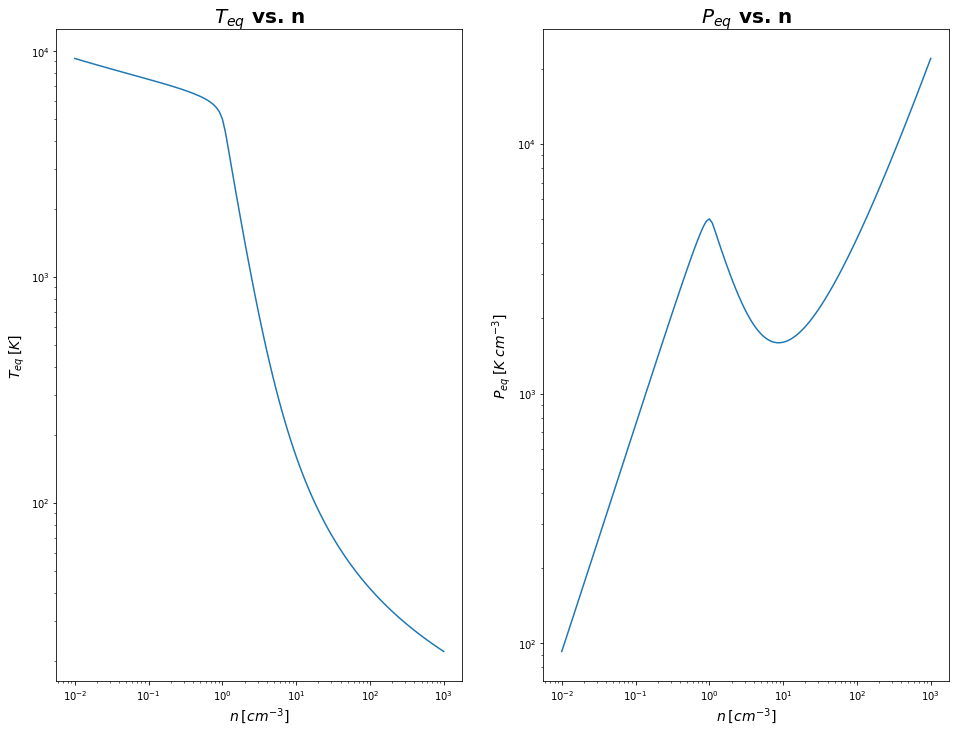

In [33]:
fig = plt.figure(figsize = (16,12))

ax_1 = plt.subplot(121)

ax_1.set_xscale('log',basex = 10)
ax_1.set_yscale('log',basey = 10)

ax_1.plot(n_array,temp_solutions)
ax_1.set_title(r'$T_{eq}$ vs. n',fontsize = 20,fontweight = 'bold')
ax_1.set_xlabel(r'$n \:[cm^{-3}]$',fontsize = 14,fontweight = 'bold')
ax_1.set_ylabel(r'$T_{eq} \:[K]$ ',fontsize = 14,fontweight = 'bold')

ax_2 = plt.subplot(122)

ax_2.set_xscale('log',basex = 10)
ax_2.set_yscale('log',basey = 10)

ax_2.plot(n_array,p_eq)
ax_2.set_title(r'$P_{eq}$ vs. n',fontsize = 20,fontweight = 'bold')
ax_2.set_xlabel(r'$n \:[cm^{-3}]$',fontsize = 14,fontweight = 'bold')
ax_2.set_ylabel(r'$P_{eq} \:[K \; cm^{-3}]$ ',fontsize = 14,fontweight = 'bold')

#### Part D (1 point)

Newton-Raphson iteration converges quadratically, with the error after iteration i being:

$$\epsilon_i ≈ \left| T_{eq}*\frac{L′′(T_{eq})}{2L′(T_{eq})}\right|\;\epsilon^2_{i−1} ≡ C \epsilon^2_{i−1}$$

In other words, near a root, the number of significant digits approximately doubles with each step. That’s nice, and it means that your Newton-Raphson program should have been extremely fast: after just

$$N^{NR}_{iter} =\log_2 \left(\frac{\log (C\,\epsilon)}{\log (C\epsilon_0)}\right)\text{   (4)   }$$

iterations, the error is $\leq \epsilon$. Let’s check this. 

Perform a N-R iteration with ε = 10<sup>−10</sup> for n = $10^{−2}$ at the $T_0$ from part (b). How many iterations did it take to converge? Was it roughly equal to equation (4)? (Isn’t that so much nicer than bisection?!)

In [39]:
n = 1e-2

T_1 = bracket[0][0].value
T_2 = bracket[0][1].value


T_0 = bracket_midpoint(T_1,T_2)

root, iterations = newton_raphson(T_0,n)

print('We found a root at T = {} in {} iterations'.format(root, iterations))


df_teq = grad_L(n,root) #first derivaative of L at this point
ddf_teq = hess_L(n,root) #second derivative of L at this point
eps = 1e-10 #tolerance
eps_0 = epsilon(T_0,root) #initial error

error_constant = np.abs(root*ddf_teq/(2*df_teq)) #C defined in the equation above

#predicted number of iterations
N_NRiter = np.log2(np.log10(error_constant*eps)/np.log10(error_constant*eps_0))


print('Newton-Raphson predicts {:.2f} iterations, which is very close to what our algorithm did.'.format(N_NRiter))


We found a root at T = 9272.103960460163 in 5 iterations
Newton-Raphson predicts 3.99 iterations, which is very close to what our algorithm did.


#### Part E (1 point)

Now start a Newton-Raphson iteration for $n = 10^{−2}$ at $T_0 = 5000$. What happened? Why?

In [40]:
n_e = 1e-2
T_0_e = 5000

root,it_e = newton_raphson(T_0_e,n_e)

print(root)

nan


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in sqrt
  if __name__ == '__main__':
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in sqrt
  if sys.path[0] == '':
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':


* When starting a NR iteration from this point, the root immediately climbs higher and higher, until eventually we get an error. This is because the derivative at this point is *almost* 0, and thus the update step shoots the root off almost horizontally.

* For example, the first step has T = 5000 (our initial guess). On the next iteration, T becomes 528062 K, and then becomes -1835979.5 (before becoming nan). The derivative at each step is: 3.8 x 10<sup>-32</sup>, 6.8 x 10<sup>-28</sup>, and nan. Both of the floats are essentially zero, which makes the update step shoot off farther and farther.

### Problem Two: Solving Kepler's equation

The study of orbital mechanics brings with it a lovely assortment of opaque 17th-century words like “eccentric anomaly”, “true anomaly”, “mean anomaly”, “longitude of the ascending node”, “argument of periapsis”... the list goes on. If you’d like know what some of these terms actually mean and assure yourself that knowledge procured more than four centuries ago has not been lost on the collegiate class of the modern human species, you can find a discussion of the so-called “two-body problem” and its solution at the end of this problem set. But if you’re eager to skip the physics lesson and get right to scoring some homework points, here’s the problem as succinctly as I can state it...

The motion of two gravitationally interacting bodies with total mass *M* in an elliptical orbit with semi-major axis *a* may be described parametrically in polar coordinates [r(t), θ(t)] once the following equation (“Kepler’s equation”) is solved for the angle E = E(t):

$$E - e \sin E = \Omega \cdot (t - \tau)$$

where 0 ≤ e < 1 is the eccentricity of the orbit, $\Omega = \left(\frac{GM}{a^3}\right)^{1/2}$ is the orbital frequency (via Kepler’s third law), and $\tau$ is the time the objects were at there closest pass (periapsis).

For e = 0, the equation above traces out a circle in the orbital plane: r(t) = a and $\theta(t) = E = \Omega(t-\tau)$. Otherwise, the equation is implicit and must be solved numerically.

$$E - e \sin E - \Omega \cdot (t - \tau) = 0$$

#### Part A (5 points)

Go here: https://exoplanets.nasa.gov/exoplanet-catalog/1343/hat-p-21-b/. You’ll find information about HAT-P-21b, a gas giant exoplanet orbiting a 0.947-M⊙ G- type star that was discovered by our very own Prof. Gaspar Bakos and Dr. Joel Hartman in 2010 using the Hungarian-made Automated Telescope Network (HATNet).

Record the observationally inferred values of e, a, and Ω for this two-body system. Set τ = 0, solve Kepler’s equation using Newton-Raphson iteration, and plot the resulting values of E/2π vs. t (in yr). (Don’t use some pre-packaged routine like scipy.optimize.newton; roll your own.) Be sure to explain your choice of initial guess for the iteration.

For HAT-P-21b, we found
* e = 0.23
* a = 0.0494 AU
* Ω = $\frac{2\pi}{period}$ = $\frac{2\pi}{4.1 days}$ = 1.77 Hz

Our initial guess for the eccentric anomaly for the iteration is E=0, because at t=0 at periapsis and with a small eccentricity (take e = 0), the equation reads $E - 0* \sin E - \Omega \cdot (t - \tau) = E + 0 - 0 = 0$

In [41]:
def keplers_eq(Ecc_anom, ecc,period,t,tau):
    return Ecc_anom - ecc*np.sin(Ecc_anom) - period*(t-tau)

def keplers_eq_grad(Ecc_anom,ecc):
    '''first derivative of keplers equation wrt Eccentric anomaly'''
    return 1-ecc*np.cos(Ecc_anom)

def newton_raphson_kepler(guess_i,ecc,period,t,tau,itrn_max = 1000,eps = 1e-10):
    xold = guess_i              # initial guess for NR iteration

    # begin NR iteration
    notdone = True
    itrtn = 0
    
    while (notdone and itrtn < itrn_max):
        #print('iteration {}'.format(itrtn))
        f = keplers_eq(xold,ecc,period,t,tau)   # compute f at guess
        df = keplers_eq_grad(xold,ecc)       # compute df/dx at guess
        
        if (df != 0):               # if df/dx != 0, proceed
            #print('continuing')
            xnew = xold - f/df      # update guess using local slope
            error = abs(xnew-xold)  # compute change in answer
            if (error > eps*xnew):       # if change is more than tolerance
              xold = xnew           # set update as new guess for next iter
              itrtn += 1            # increment iteration counter
            else:
              root = xnew           # otherwise, accept as root
              notdone = False
            #print("At iteration %2d, the numerical root is %16.13f with \
                  #iteration error %.11e" % (itrtn, xnew, error/xnew ))
        else:
            print("derivative is zero!")
            break
        #print(error)

    return root,itrtn

period_p21b = (4.1*u.day).to(u.s) #orbital period of the planet in seconds
omega_p21b = 2*np.pi/period_p21b #angular period of the planet in rads/second
ecc_p21b = 0.23 #eccentricity
a_p21b = (0.0494*u.au).to(u.m).value #semi-major axis in meters
tau_p21b = 0 #time of periapsis (we set it to 0)

t = np.linspace(0,((0.5*u.yr).to(u.s)).value,num = 5000) #timesteps for half of a year in seconds

ecc_anoms_p21b = np.zeros(len(t)) #array to store eccentric anomalies

ecc_guess_init = 0.0
iterations_p21b = np.zeros(len(t)) #array to store iterations for NR

for i in range(len(t)):
    root,itrtn = newton_raphson_kepler(ecc_guess_init,ecc_p21b,omega_p21b.value,t[i],tau_p21b)
    ecc_anoms_p21b[i] = root
    iterations_p21b[i] = itrtn
    #guess for the next timestep is the value from the previous one
    ecc_guess_init = root

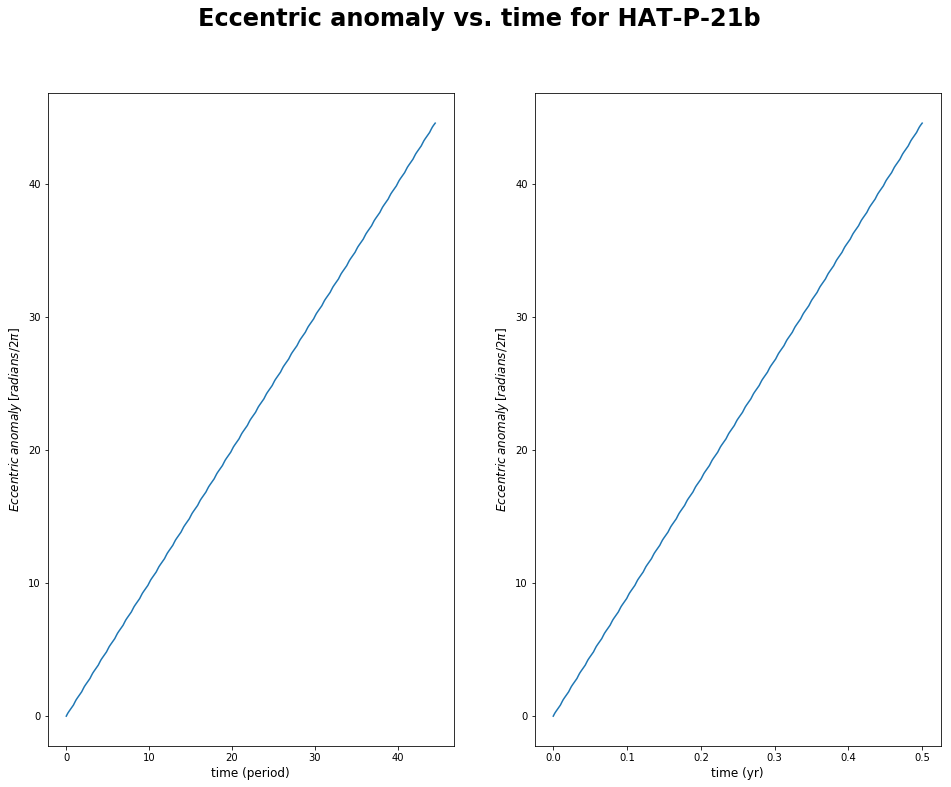

In [42]:
fig = plt.figure(figsize = (16,12))
fig.suptitle(r"Eccentric anomaly vs. time for HAT-P-21b",fontsize = 24,fontweight='bold')
ax=plt.subplot(121)

ax.plot(t/period_p21b,ecc_anoms_p21b/(2*np.pi))

ax.set_xlabel(r'time (period)',fontsize = 12)
ax.set_ylabel(r'$Eccentric \, anomaly \, [radians / 2 \pi]$',fontsize = 12)


ax=plt.subplot(122)

ax.plot((t*u.s).to(u.yr),ecc_anoms_p21b/(2*np.pi))
ax.set_xlabel(r'time (yr)',fontsize = 12)
ax.set_ylabel(r'$Eccentric \, anomaly \, [radians / 2 \pi]$',fontsize = 12)


plt.show()

#### Part B (2 points)

The polar angle θ is related to E via:

$$ \tan\left(\frac{\theta}{2}\right) = \sqrt{\frac{1 + e}{1 - e}} \: \tan\left(\frac{E}{2}\right)$$

The radian distance r may then be computed from Kepler's first law:

$$r = \frac{a\,(1- e^2)}{1 + e\cos\theta}$$

Use these to plot the orbit. Be sure to label all axes, and mind the aspect ratio of your plot so that a circle looks like a circle and an ellipse looks like an ellipse.

In [43]:
theta_p21b = 2*np.arctan(np.sqrt((1+ecc_p21b)/(1-ecc_p21b))*np.tan(ecc_anoms_p21b/2)) #theta at each E
r_p21b = a_p21b*(1 - ecc_p21b**2)/(1 + ecc_p21b*np.cos(theta_p21b)) #radii at each angle theta

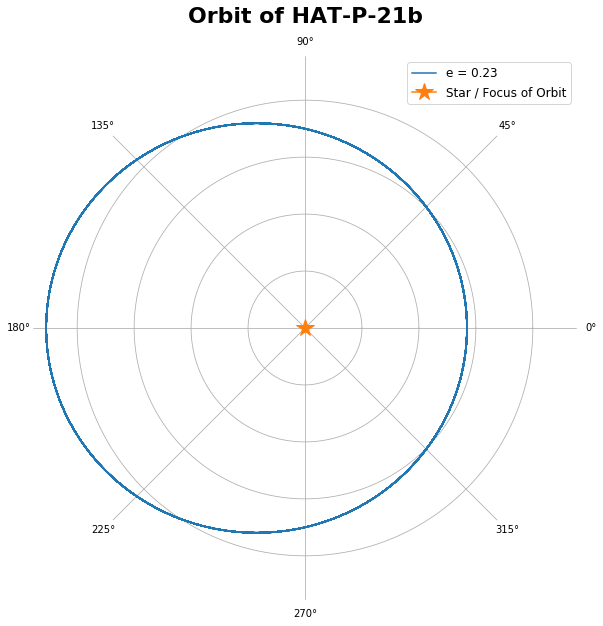

In [44]:
fig = plt.figure(figsize = (10,10))
ax = plt.subplot(111,polar=True)

plt.polar(theta_p21b,r_p21b,label = 'e = 0.23')
plt.polar(0,0,marker = '*',markersize = 18,label='Star / Focus of Orbit')
ax.spines['polar'].set_visible(False)

ax.set_yticklabels([])
#ax.set_xticklabels([])

ax.set_title('Orbit of HAT-P-21b',fontsize = 22,fontweight='bold')

plt.legend(fontsize = 12)
plt.show()

#### Part C (3 points)

Go here: https://exoplanets.nasa.gov/exoplanet-catalog/6636/hd-43197-b/ Repeat parts (a) and (b) for this two-body system. 

The orbit of this exoplanet has a large eccentricity, so you should re-evaluate your choice of initial guess for the iteration. To do so, answer the following:

*What happens to the N-R iteration at large values of eccentricity when $\frac{E}{2\pi}$ is close to an integer? Why might this be bad?*

For HD 43197 b, we found
* e = 0.83
* a = 0.92 AU
* Ω = $\frac{2\pi}{period}$ = $\frac{2\pi}{327.8 days}$ = $2.2x10^{-7}$ Hz

Our initial guess for the eccentric anomaly for the iteration is E=0, because at t=0 at periapsis, the equation reads $E - e* \sin E - \Omega \cdot (t - \tau) = E + e* \sin E = 0$ and in order to have both of these terms equal zero we must have E=0 so that $0-e*\sin0=0$

In [45]:
#HD 43197 b

period_43197b = (327.8*u.day).to(u.s) 

omega_43197b = 2*np.pi/period_43197b
ecc_43197b = 0.83
a_43197b = (0.92*u.au).to(u.m).value
tau_43197b = 0

#timesteps for one orbit in seconds
t_43197b = np.linspace(0,((3*u.yr).to(u.s)).value,num = 5000)

ecc_anoms_43197b = np.zeros(len(t_43197b))
iterations_43197b = np.zeros(len(t_43197b))

ecc_guess_init = 0

for i in range(len(t)):
    root,itrtn = newton_raphson_kepler(ecc_guess_init,ecc_43197b,omega_43197b.value,t_43197b[i],tau_43197b)
    ecc_anoms_43197b[i] = root
    iterations_43197b[i] = itrtn
    ecc_guess_init = root

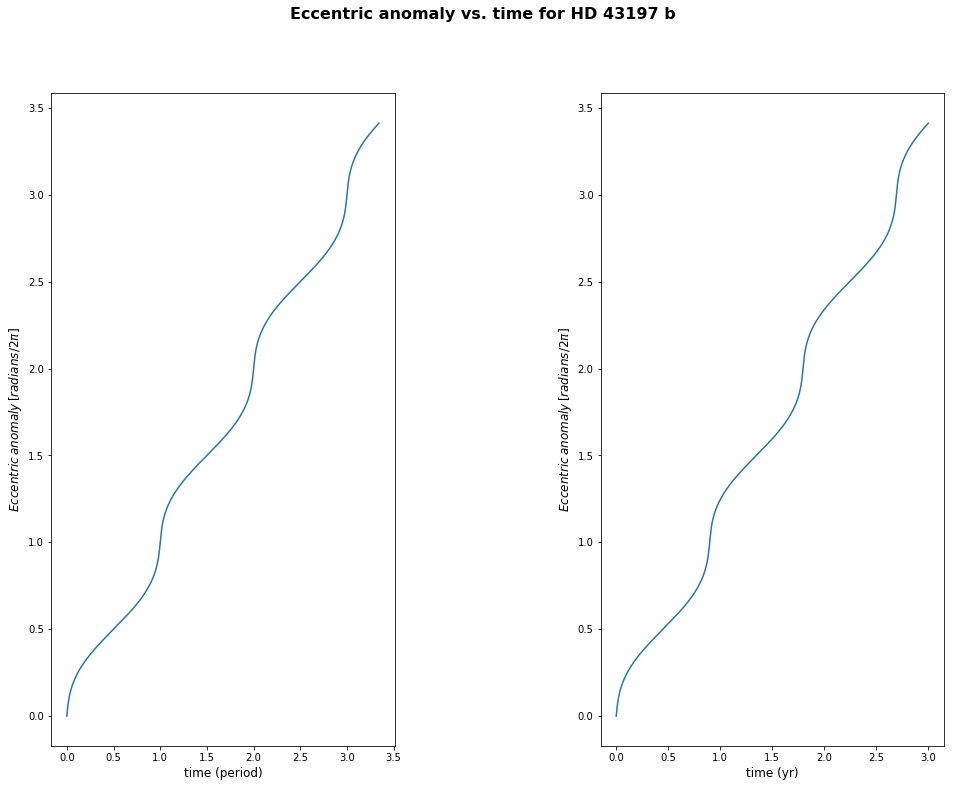

In [46]:
fig = plt.figure(figsize = (16,12))
fig.suptitle(r"Eccentric anomaly vs. time for HD 43197 b",fontsize = 16,fontweight='bold')
ax = plt.subplot(121)


ax.plot(t_43197b/period_43197b.value,ecc_anoms_43197b/(2*np.pi))
#ax.set_title(r"Eccentric anomaly vs. time for HD 43197 b",fontsize = 16,fontweight='bold')
ax.set_xlabel(r'time (period)',fontsize = 12)
ax.set_ylabel(r'$Eccentric \, anomaly \, [radians / 2 \pi]$',fontsize = 12)

ax = plt.subplot(122)

ax.plot((t_43197b*u.s).to(u.yr),ecc_anoms_43197b/(2*np.pi))
#ax.set_title(r"Eccentric anomaly vs. time for HD 43197 b",fontsize = 16,fontweight='bold')
ax.set_xlabel(r'time (yr)',fontsize = 12)
ax.set_ylabel(r'$Eccentric \, anomaly \, [radians / 2 \pi]$',fontsize = 12)

plt.subplots_adjust(wspace = 0.6)

plt.show()

In [47]:
theta_43197b = 2*np.arctan(np.sqrt((1+ecc_43197b)/(1-ecc_43197b))*np.tan(ecc_anoms_43197b/2))
r_43197b = a_43197b*(1 - ecc_43197b**2)/(1 + ecc_43197b*np.cos(theta_43197b))

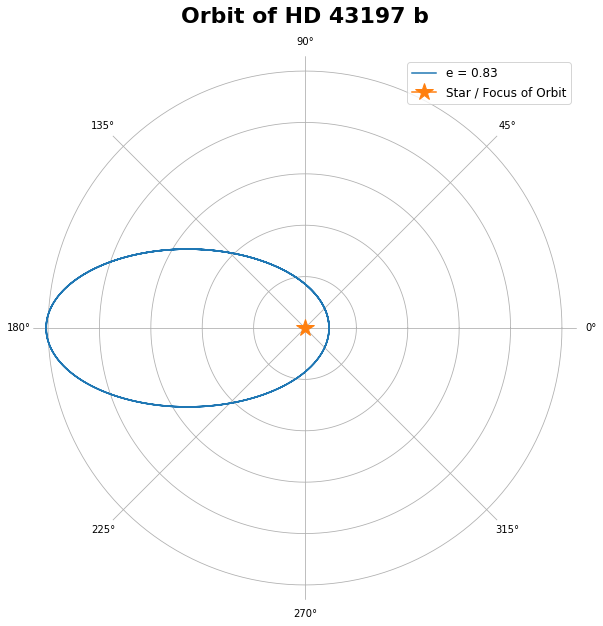

In [48]:
fig = plt.figure(figsize = (10,10))
ax = plt.subplot(111,polar=True)

plt.polar(theta_43197b,r_43197b,label = 'e = '+str(ecc_43197b))
plt.polar(0,0,marker = '*',markersize = 18,label='Star / Focus of Orbit')
ax.spines['polar'].set_visible(False)

ax.set_yticklabels([])
#ax.set_xticklabels([])

ax.set_title('Orbit of HD 43197 b',fontsize = 22,fontweight='bold')

plt.legend(fontsize = 12)
plt.show()

At large values of eccentricity when $E/2\pi$ is close to an integer, the derivative of $E - e \sin E - \Omega \cdot (t - \tau)$ equals $1 - e \cos E = 0$, and since e is large ($e\approx1$) and $E/2\pi$ is close to an integer ($\cos E \approx1$), the derivative $\approx1-1\approx0$. Newton-Raphson corrects by $\frac{f(x)}{f^{'}(x)}$, so dividing by $f^{'}(x)\approx0$ would cause the correction to shoot up, and make it impossible to converge.